In [67]:
%reset -f

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from functions import *

from statsmodels.tsa.seasonal import seasonal_decompose

# Load each
datasets = {}
for hour in range(24):
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

y_train_deseasonal = {}
y_test_deseasonal = {}
seasonal_test = {}

for hour in range(24):
    decomposition_train = seasonal_decompose(y_train[hour], model='additive', period=52)
    seasonal_train = decomposition_train.seasonal.reshape(-1, 1)
    y_train_deseasonal[hour] = y_train[hour] - seasonal_train

    seasonal_test[hour] = seasonal_train[:len(y_test[hour])].reshape(-1, 1)
    y_test_deseasonal[hour] = y_test[hour] - seasonal_test[hour]

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}

pca_train = {}
pca_test = {}

for hour in range(24):
    data_dimreduc, _, _, _, _ = PCA_dimreduc(weather_train[hour], weather_train[hour], 0.85)
    pca_train[hour] = data_dimreduc

    data_dimreduc, _, _, _, _ = PCA_dimreduc(weather_train[hour], weather_test[hour], 0.85)
    pca_test[hour] = data_dimreduc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## AR(1) with constant

SMAPE baseline (24 lags) out of sample prediction: [[308.07923815]
 [ 55.84089138]
 [ 75.46517543]]


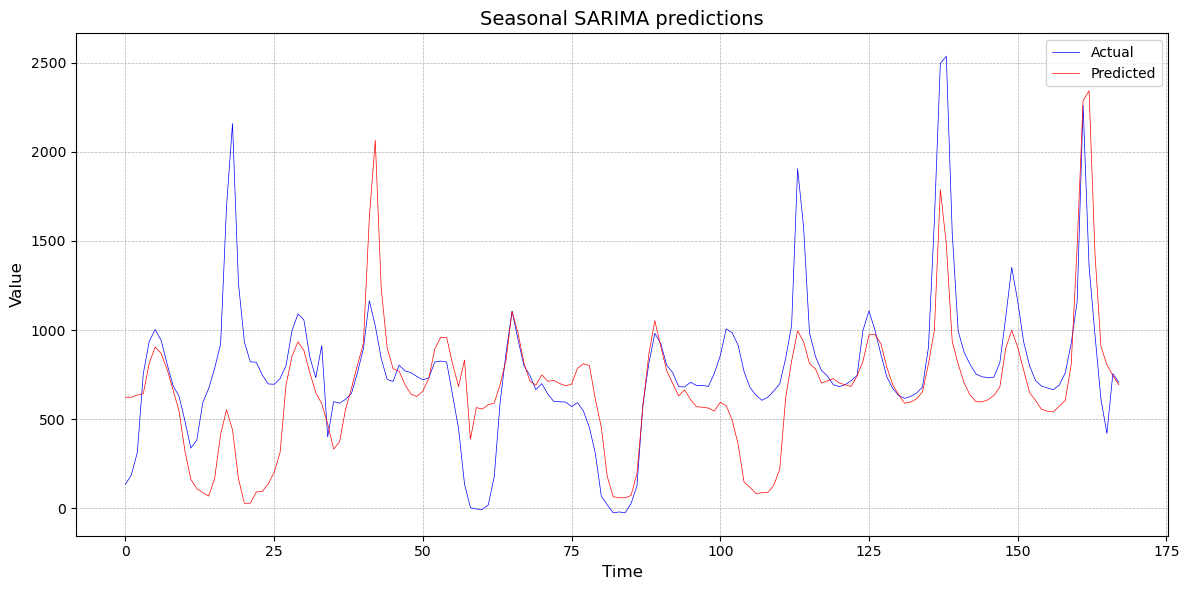

In [76]:
p, d, q = 1, 0, 0 
P, D, Q, s = 0, 0, 0, 0 

smoother_output = 0

predictions_dict = {}

for hour in range(24):
    model = SARIMAX(
        y_train_deseasonal[hour],
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        **{'smoother_output': smoother_output},
        trend='c'
    )
    results = model.fit(disp=False)

    new_results = results.append(y_test_deseasonal[hour], refit=False)

    predictions = new_results.predict(start=len(y_train_deseasonal[hour]), end=len(y_train_deseasonal[hour]) + len(y_test_deseasonal[hour]) - 1).reshape(-1, 1)

    predictions_dict[hour] = predictions + seasonal_test[hour]

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

rmse, smape, rmae = out_of_sample_pred(combined_test, combined_predictions)

model_1 = np.array([[rmse], [smape], [rmae]])
combined_predictions_model_1 = combined_predictions

print(f'SMAPE baseline (24 lags) out of sample prediction: {model_1}')

plot_actual_vs_predicted(combined_test, combined_predictions_model_1, "Seasonal SARIMA predictions")